<a href="https://colab.research.google.com/github/mbolaris/coin_detection/blob/master/Train_PCGS_Coin_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Connect to Google Drive 

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Clone the `coin_detection` repository

In [2]:
import os

repo_url = 'https://github.com/mbolaris/coin_detection'

%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'coin_detection'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 518 (delta 41), reused 0 (delta 0), pack-reused 445
Receiving objects: 100% (518/518), 31.49 MiB | 55.79 MiB/s, done.
Resolving deltas: 100% (290/290), done.
/content/coin_detection
Already up to date.


## Install required packages

In [3]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib
!pip install -q pycocotools
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
!python object_detection/builders/model_builder_test.py

/content
/content/models/research

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

............s...
----------------------------------------------------------------------
Ran 16 tests in 0.076s

OK (skipped=1)


## Download the dataset generated from scraping the PCGS website 

In [4]:
import shutil
import os

# Download and unpack dataset
%cd /content

RAW_DATASET_DIR = '/content/raw_dataset'

if (os.path.exists(RAW_DATASET_DIR)):
    shutil.rmtree(RAW_DATASET_DIR)

# The scraped PCGS dataset
dataset_folder_id = '1CTHfDTjws5DBdtpnbWr0qPDhNwZzgf5t'

file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(dataset_folder_id)}).GetList()

for file1 in sorted(file_list, key = lambda x: x['title']):
    if file1['title'].endswith(".gz"):
      print('Downloading {} from Google Drive'.format(file1['title']))
      file1.GetContentFile(file1['title'])
      print('Unpacking {}'.format(file1['title']))
      shutil.unpack_archive(file1['title'], RAW_DATASET_DIR)
      print('Removing {}'.format(file1['title']))
      os.remove(file1['title'])

pcgs_number_map_file_id = '1lEPih1ZZcJTukWwmD05bgIMnV7SFiL3r'
file = drive.CreateFile({'id':pcgs_number_map_file_id})
file.GetContentFile('/content/raw_dataset/pcgs_number_map.json')
shutil.copy(RAW_DATASET_DIR + '/pcgs_number_map.json', '/content/coin_detection/images/train/pcgs_number_map.json')
shutil.copy(RAW_DATASET_DIR + '/pcgs_number_map.json', '/content/coin_detection/images/test/pcgs_number_map.json')


/content
Unpacking generated_dataset.tar.gz
Removing generated_dataset.tar.gz


'/content/coin_detection/images/test/pcgs_number_map.json'

##Move a 1/10th of the generated data to test and the rest to train

In [0]:
import os
import shutil
train_dir = "/content/coin_detection/images/train"
test_dir  = "/content/coin_detection/images/test"
dataset_import_dir = RAW_DATASET_DIR

fullpath = os.path.join

for dirname, dirnames, filenames in os.walk(dataset_import_dir):
  for filename in filenames:
    source = fullpath(dirname, filename)
    if filename.endswith("3.xml") or filename.endswith("3.jpg"):
      shutil.move(source, fullpath(test_dir, filename))
    elif filename.endswith(".xml") or filename.endswith(".jpg"):
      shutil.move(source, fullpath(train_dir, filename))

## Prepare `tfrecord` files

In [6]:
%cd {repo_dir_path}

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `annotations/` directory as well.
!python xml_to_csv.py -i images/train -o annotations/train_labels.csv -l annotations

# Convert test folder annotation xml files to a single csv.
!python xml_to_csv.py -i images/test -o annotations/test_labels.csv

# Generate `test.record`
!python generate_tfrecord.py --csv_input=annotations/test_labels.csv --output_path=annotations/test.record --img_path=images/test --label_map annotations/label_map.pbtxt

# Generate `train.record`
!python generate_tfrecord.py --csv_input=annotations/train_labels.csv --output_path=annotations/train.record --img_path=images/train --label_map annotations/label_map.pbtxt

/content/coin_detection
images/train/pcgs_number_map.json
Successfully converted xml to csv.
Generate `annotations/label_map.pbtxt`
images/test/pcgs_number_map.json
Successfully converted xml to csv.
Successfully created the TFRecords: /content/coin_detection/annotations/test.record
Successfully created the TFRecords: /content/coin_detection/annotations/train.record


## Pick a Model and Configs and Hyperparameters

More pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [0]:
test_record_fname = '/content/coin_detection/annotations/test.record'
train_record_fname = '/content/coin_detection/annotations/train.record'
label_map_pbtxt_fname = '/content/coin_detection/annotations/label_map.pbtxt'

# Number of training steps.
num_steps = 20000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Download and repurpose a base model (Option 1)

In [0]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


## Download a saved model from Google Drive (Option 2)

In [8]:
# Download our saved modle

saved_modle_id = '1E_3OtOIeYkb9oLWHJCGibxdp8MeoMgZo'

MODEL_FILE = MODEL + '.tar.gz'
DEST_DIR = '/content/models/research/pretrained_model'

%cd /content/models/research/
!rm -f {MODEL_FILE}
# Initialize GoogleDriveFile instance with file id.
file_imp = drive.CreateFile({'id':saved_modle_id})
file_imp.GetContentFile(MODEL_FILE) 

import shutil
shutil.unpack_archive(MODEL_FILE, 'pretrained_model')
!ls -l pretrained_model

/content/models/research
total 40180
-rw-r--r-- 1 root root       77 Mar 25 06:13 checkpoint
-rw-r--r-- 1 root root 20143803 Mar 25 06:13 frozen_inference_graph.pb
-rw-r--r-- 1 root root 19444692 Mar 25 06:13 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root    14128 Mar 25 06:13 model.ckpt.index
-rw-r--r-- 1 root root  1516905 Mar 25 06:13 model.ckpt.meta
-rw-r--r-- 1 root root     4278 Mar 25 01:56 pipeline.config
drwxr-xr-x 3 root root     4096 Mar 25 01:56 saved_model


## Configuring a Training Pipeline

In [0]:
import os

fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)
assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)
model_dir = 'training/'

###Modify the sample pipeline to use our hyper parameters and work with our data

In [0]:
import re

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

 
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

## Check out the pipeline configuration

In [11]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 14
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect

## Run Tensorboard(Optional)

In [12]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2019-03-25 14:02:00--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.73.94.166, 35.173.3.255, 52.72.250.2, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.73.94.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13584026 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.95M  59.6MB/s    in 0.2s    

2019-03-25 14:02:00 (59.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13584026/13584026]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [14]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://561f63a3.ngrok.io


## Train the model

In [15]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.
2019-03-25 14:02:44.463657: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-03-25 14:02:44.463976: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x1352ef20 executing computations on platform Host. Devices:
2019-03-25

## Exporting the Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which can be used to perform the object detection. 

In [16]:
import re
import numpy as np

output_directory = './inference_graph'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-20000
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
185 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by

In [0]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

### Upload the model to Google Drive


In [21]:
import shutil
!rm -f exp_g.tar.gz
shutil.make_archive('exported_inference_graph', 'gztar', 'inference_graph')

# Create & upload a file.

import datetime
upload_filename = datetime.datetime.now().strftime("exported_inference_graph_coin_detection_%Y-%m-%d-%H-%M-%S.tar.gz")
uploaded = drive.CreateFile({'title': upload_filename})
uploaded.SetContentFile('exported_inference_graph.tar.gz')
uploaded.Upload()
print('Uploaded {} with ID {}'.format(upload_filename, uploaded.get('id')))

Uploaded exported_inference_graph_coin_detection_2019-03-25-18-34-13.tar.gz with ID 1-u7T0vGz_wgDtKPcEroAYgn0DpnKDMQx


## Run inference test
Test with images in repository `coin_detection/test_images` directory.

In [22]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test_images")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/coin_detection/test_images/test2.jpg', '/content/coin_detection/test_images/test1.jpg']


/content/models/research/object_detection


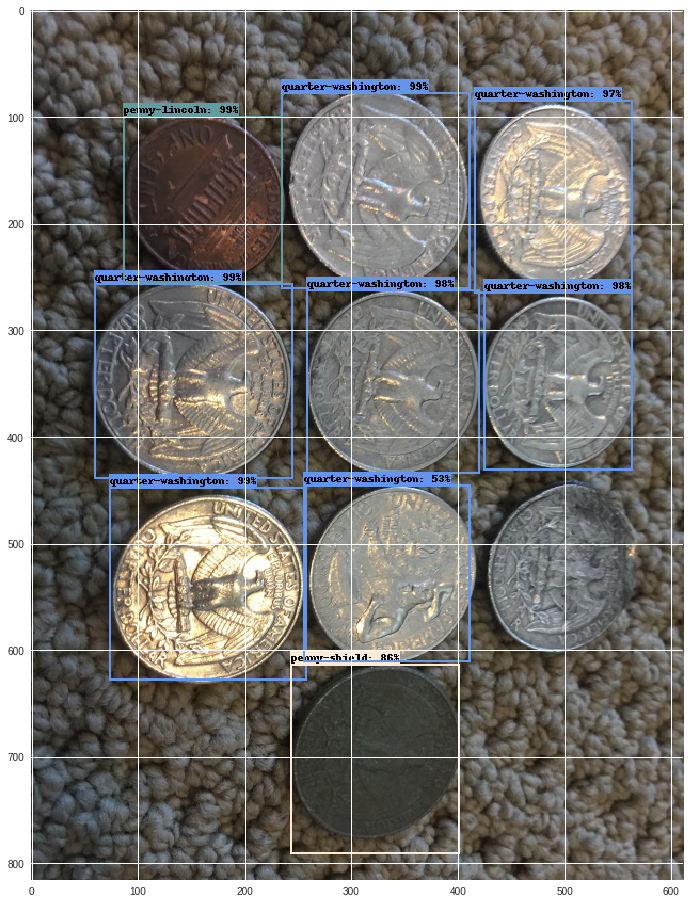

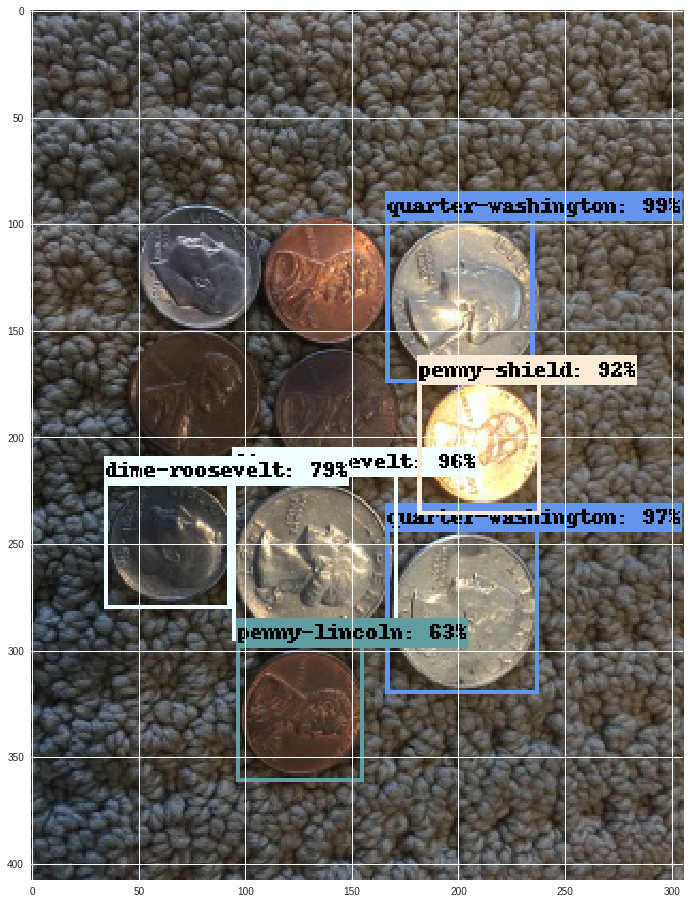

In [24]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (24, 16)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

In [0]:
#!kill -9 -1 # !!!!!!!!reset virtual machine